# Airborne magnetic survey of Afghanistan

https://ngdc.noaa.gov/geomag/aromag.shtml

License: [public domain](https://www.ngdc.noaa.gov/ngdcinfo/privacy.html#copyright-notice)

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pooch
import pyproj
import pygmt

## Download the data archive

Use Pooch to download the data archive and fetch the CSV file only (not the PDF reports included).

In [2]:
surveys = "06G 06C 06H 06F 06D 06B 08A 06E 06A".lower().split()
hashes = [
    "sha256:8469c1a4244ba4a505a199f9258ec47409efb8c09607a1d7d038cc32243f9c99",
    "sha256:045895371fee9f7f4873541a8092fd513070a81f238423c9cfb508da8ff655a9",
    "sha256:f080967ea5730e6e7ea95b0586d54f5b31d1d6475c1c77a0c86088d843b643a2",
    "sha256:beacc36ce205ff507724a2a65d1985fbb8734e609662fc4336bf17792944ac13",
    "sha256:f44aab329b3bcf8ab2260c63cbdf35feb1c993b1646b77bc747816b506126b96",
    "sha256:5e71f99c1a1de5be9e8fb4f8c9a162851eb758c5d6baace66c2c67b536732cd5",
    "sha256:a905e49db417fff5c4e087203c6455f4e7bc3a386e67abfa8f2f36b8da027f20",
    "sha256:8ee85a167dc904085aab6bdb88155171a5a1cefc71e51fdea3a920d86e324f4f",
    "sha256:a5129bc3e0ad6e13c527c0115aef135508987712f371b19788fd3aef189470ee",
]
fnames = []
for survey, sha_hash in zip(surveys, hashes):
    url = f"https://www.ngdc.noaa.gov/mgg/trk/aeromag/nrl_afghanistan/afghan_mag{survey}/afghan_mag{survey}.zip"
    data_file = f"afghan_mag{survey}/data/mag88t/afghan_mag{survey}.m88t"
    fname = pooch.retrieve(
        url,
        known_hash=sha_hash,
        # Unpack and return only the actual data, not the reports.
        processor=pooch.Unzip(members=[data_file]),
    )
    fnames.append(fname[0])

In [3]:
for fname in fnames:
    print(f"{os.path.split(fname)[-1]}: {os.path.getsize(fname) / 1e6} Mb")

afghan_mag06g.m88t: 7.261322 Mb
afghan_mag06c.m88t: 8.004715 Mb
afghan_mag06h.m88t: 10.077975 Mb
afghan_mag06f.m88t: 24.005835 Mb
afghan_mag06d.m88t: 32.151084 Mb
afghan_mag06b.m88t: 48.634184 Mb
afghan_mag08a.m88t: 62.593679 Mb
afghan_mag06e.m88t: 61.938494 Mb
afghan_mag06a.m88t: 393.584462 Mb


## Read the data

Use pandas to load the CSV file.

In [10]:
def to_datetime(line):
    """
    Convert the date and time in seconds to a proper datetime.
    """
    date, time = line
    date = str(int(date))
    hour = int(time // 3600)
    minute = int((time - 3600 * hour) // 60)
    second = (time - 3600 * hour - 60 * minute)
    year = date[:4]
    month = date[4:6]
    day = date[6:]
    if hour > 23:
        hour = hour - 24
        day = str(int(day) + 1)
    return f"{year}-{month}-{day} {hour:02d}:{minute:02d}:{second:05.2f}" 

In [31]:
survey

,survey_id,date,time_seconds,latitude,longitude,height_geometric_m,magnetic_amplitude_nt,diurnal_correction_nt,igrf_nt,time_utc
0,AFGHAN_MAG06C,20060625,55825.47,34.604619,69.112581,8870.45,49460.73,-11.32,49499.81,2006-06-25 15:30:25.470
1,AFGHAN_MAG06C,20060625,55825.57,34.604595,69.112771,8870.44,49460.71,-11.32,49499.82,2006-06-25 15:30:25.570
2,AFGHAN_MAG06C,20060625,55825.66,34.604570,69.112963,8870.42,49460.72,-11.32,49499.84,2006-06-25 15:30:25.660
3,AFGHAN_MAG06C,20060625,55825.77,34.604543,69.113181,8870.40,49460.68,-11.32,49499.86,2006-06-25 15:30:25.770
4,AFGHAN_MAG06C,20060625,55825.87,34.604520,69.113369,8870.39,49460.70,-11.32,49499.87,2006-06-25 15:30:25.870
...,...,...,...,...,...,...,...,...,...,...
74855,AFGHAN_MAG06C,20060728,100933.07,34.506552,69.020977,9258.03,49332.13,-6.16,49437.32,2006-07-29 04:02:13.070
74856,AFGHAN_MAG06C,20060728,100933.18,34.506667,69.020900,9257.99,49332.21,-6.16,49437.37,2006-07-29 04:02:13.180
74857,AFGHAN_MAG06C,20060728,100933.28,34.506802,69.020809,9257.95,49332.18,-6.16,49437.42,2006-07-29 04:02:13.280
74858,AFGHAN_MAG06C,20060728,100933.38,34.506918,69.020732,9257.92,49332.24,-6.16,49437.47,2006-07-29 04:02:13.380


In [34]:
pd.to_datetime(survey.date, format="%Y%m%d") + pd.to_timedelta(survey.time_seconds, unit="s")

0       2006-06-25 15:30:25.470
1       2006-06-25 15:30:25.570
2       2006-06-25 15:30:25.660
3       2006-06-25 15:30:25.770
4       2006-06-25 15:30:25.870
                  ...          
74855   2006-07-29 04:02:13.070
74856   2006-07-29 04:02:13.180
74857   2006-07-29 04:02:13.280
74858   2006-07-29 04:02:13.380
74859   2006-07-29 04:02:13.470
Length: 74860, dtype: datetime64[ns]

In [36]:
surveys = []
for fname in fnames[:7]:
    survey = pd.read_csv(
        fname, 
        sep="\t", 
        usecols=[0, 1, 2, 3, 4, 5, 13, 22, 23], 
        header=0, 
        names="survey_id date time_seconds latitude longitude height_geometric_m magnetic_amplitude_nt diurnal_correction_nt igrf_nt".split(),
    )
    survey["time_utc"] = pd.to_datetime(survey.date, format="%Y%m%d") + pd.to_timedelta(survey.time_seconds, unit="s")
    survey.pop("date")
    survey.pop("time_seconds")
    surveys.append(survey)
data = pd.concat(surveys, ignore_index=True)
del surveys
data

,survey_id,latitude,longitude,height_geometric_m,magnetic_amplitude_nt,diurnal_correction_nt,igrf_nt,time_utc
0,AFGHAN_MAG06G,35.944442,69.031739,9268.12,50168.07,-23.13,50114.36,2006-07-26 16:57:24.560
1,AFGHAN_MAG06G,35.944547,69.031822,9268.26,50168.15,-23.13,50114.42,2006-07-26 16:57:24.660
2,AFGHAN_MAG06G,35.944669,69.031922,9268.43,50168.21,-23.13,50114.48,2006-07-26 16:57:24.770
3,AFGHAN_MAG06G,35.944775,69.032008,9268.58,50168.30,-23.13,50114.54,2006-07-26 16:57:24.870
4,AFGHAN_MAG06G,35.944878,69.032092,9268.72,50168.38,-23.13,50114.60,2006-07-26 16:57:24.960
...,...,...,...,...,...,...,...,...
1722586,AFGHAN_MAG08A,32.420830,67.520298,NaN,48411.75,10.50,48372.71,2008-06-14 23:37:35.970
1722587,AFGHAN_MAG08A,32.419297,67.520320,NaN,48410.38,10.49,48371.97,2008-06-14 23:37:36.970
1722588,AFGHAN_MAG08A,32.417763,67.520341,NaN,48408.69,10.50,48371.23,2008-06-14 23:37:37.980
1722589,AFGHAN_MAG08A,32.416230,67.520362,NaN,48407.51,10.50,48370.50,2008-06-14 23:37:38.980


## Plot the data

Make a quick plot to make sure the data look OK.

In [ ]:
data["total_field_anomaly_nt"] = data.magnetic_amplitude_nt - data.diurnal_correction_nt - data.igrf_nt

In [ ]:
fig = pygmt.Figure()
scale = np.percentile(data.total_field_anomaly_nt, 99)
pygmt.makecpt(cmap="polar", series=[-scale, scale])
fig.plot(x=data.longitude, y=data.latitude, style="c0.02c", color=data.total_field_anomaly_nt, cmap=True, projection="M15c")
fig.colorbar(frame='af+l"nT"')
fig.coast(borders=1)
fig.show()

## Export

Make a separate DataFrame to export to CSV with only the chosen fields.

In [11]:
export = pd.DataFrame({  
    "line_and_segment": data.line_and_segment, 
    "year": data.year.map(lambda x: "{:d}".format(x)),  
    "longitude": data.longitude.map(lambda x: "{:.5f}".format(x)),
    "latitude": data.latitude.map(lambda x: "{:.5f}".format(x)),    
    "height_m": data.height_m.map(lambda x: "{:.0f}".format(x)),    
    "total_field_anomaly_nt": data.total_field_anomaly_nt.map(lambda x: "{:.0f}".format(x)), 
})
export

,line_and_segment,year,longitude,latitude,height_m,total_field_anomaly_nt
0,FL1-1,1955,-1.74162,53.48164,792,62
1,FL1-1,1955,-1.70122,53.48352,663,56
2,FL1-1,1955,-1.08051,53.47677,315,30
3,FL1-1,1955,-1.07471,53.47672,315,31
4,FL1-1,1955,-1.01763,53.47586,321,44
...,...,...,...,...,...,...
541503,FL-3(TL10-24)-1,1965,-4.68843,58.26786,1031,64
541504,FL-3(TL10-24)-1,1965,-4.68650,58.26786,1045,74
541505,FL-3(TL10-24)-1,1965,-4.68535,58.26790,1035,94
541506,FL-3(TL10-24)-1,1965,-4.68419,58.26787,1024,114


In [12]:
fname = "britain-magnetic.csv.xz"
export.to_csv(fname, index=False)
print(fname)
print(f"size: {os.path.getsize(fname) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(fname, alg=alg)}")

britain-magnetic.csv.xz
size: 2.669264 Mb
md5:8dbbda02c7e74f63adc461909358f056
sha256:4e00894c2e0fa5b9c547719c8ac08adb6e788a7074c0dae9fb1b2767cf494b38


## Read back the data and plot it

Verify that the output didn't corrupt anything.

In [13]:
mag = pd.read_csv(fname)
mag

,line_and_segment,year,longitude,latitude,height_m,total_field_anomaly_nt
0,FL1-1,1955,-1.74162,53.48164,792,62
1,FL1-1,1955,-1.70122,53.48352,663,56
2,FL1-1,1955,-1.08051,53.47677,315,30
3,FL1-1,1955,-1.07471,53.47672,315,31
4,FL1-1,1955,-1.01763,53.47586,321,44
...,...,...,...,...,...,...
541503,FL-3(TL10-24)-1,1965,-4.68843,58.26786,1031,64
541504,FL-3(TL10-24)-1,1965,-4.68650,58.26786,1045,74
541505,FL-3(TL10-24)-1,1965,-4.68535,58.26790,1035,94
541506,FL-3(TL10-24)-1,1965,-4.68419,58.26787,1024,114


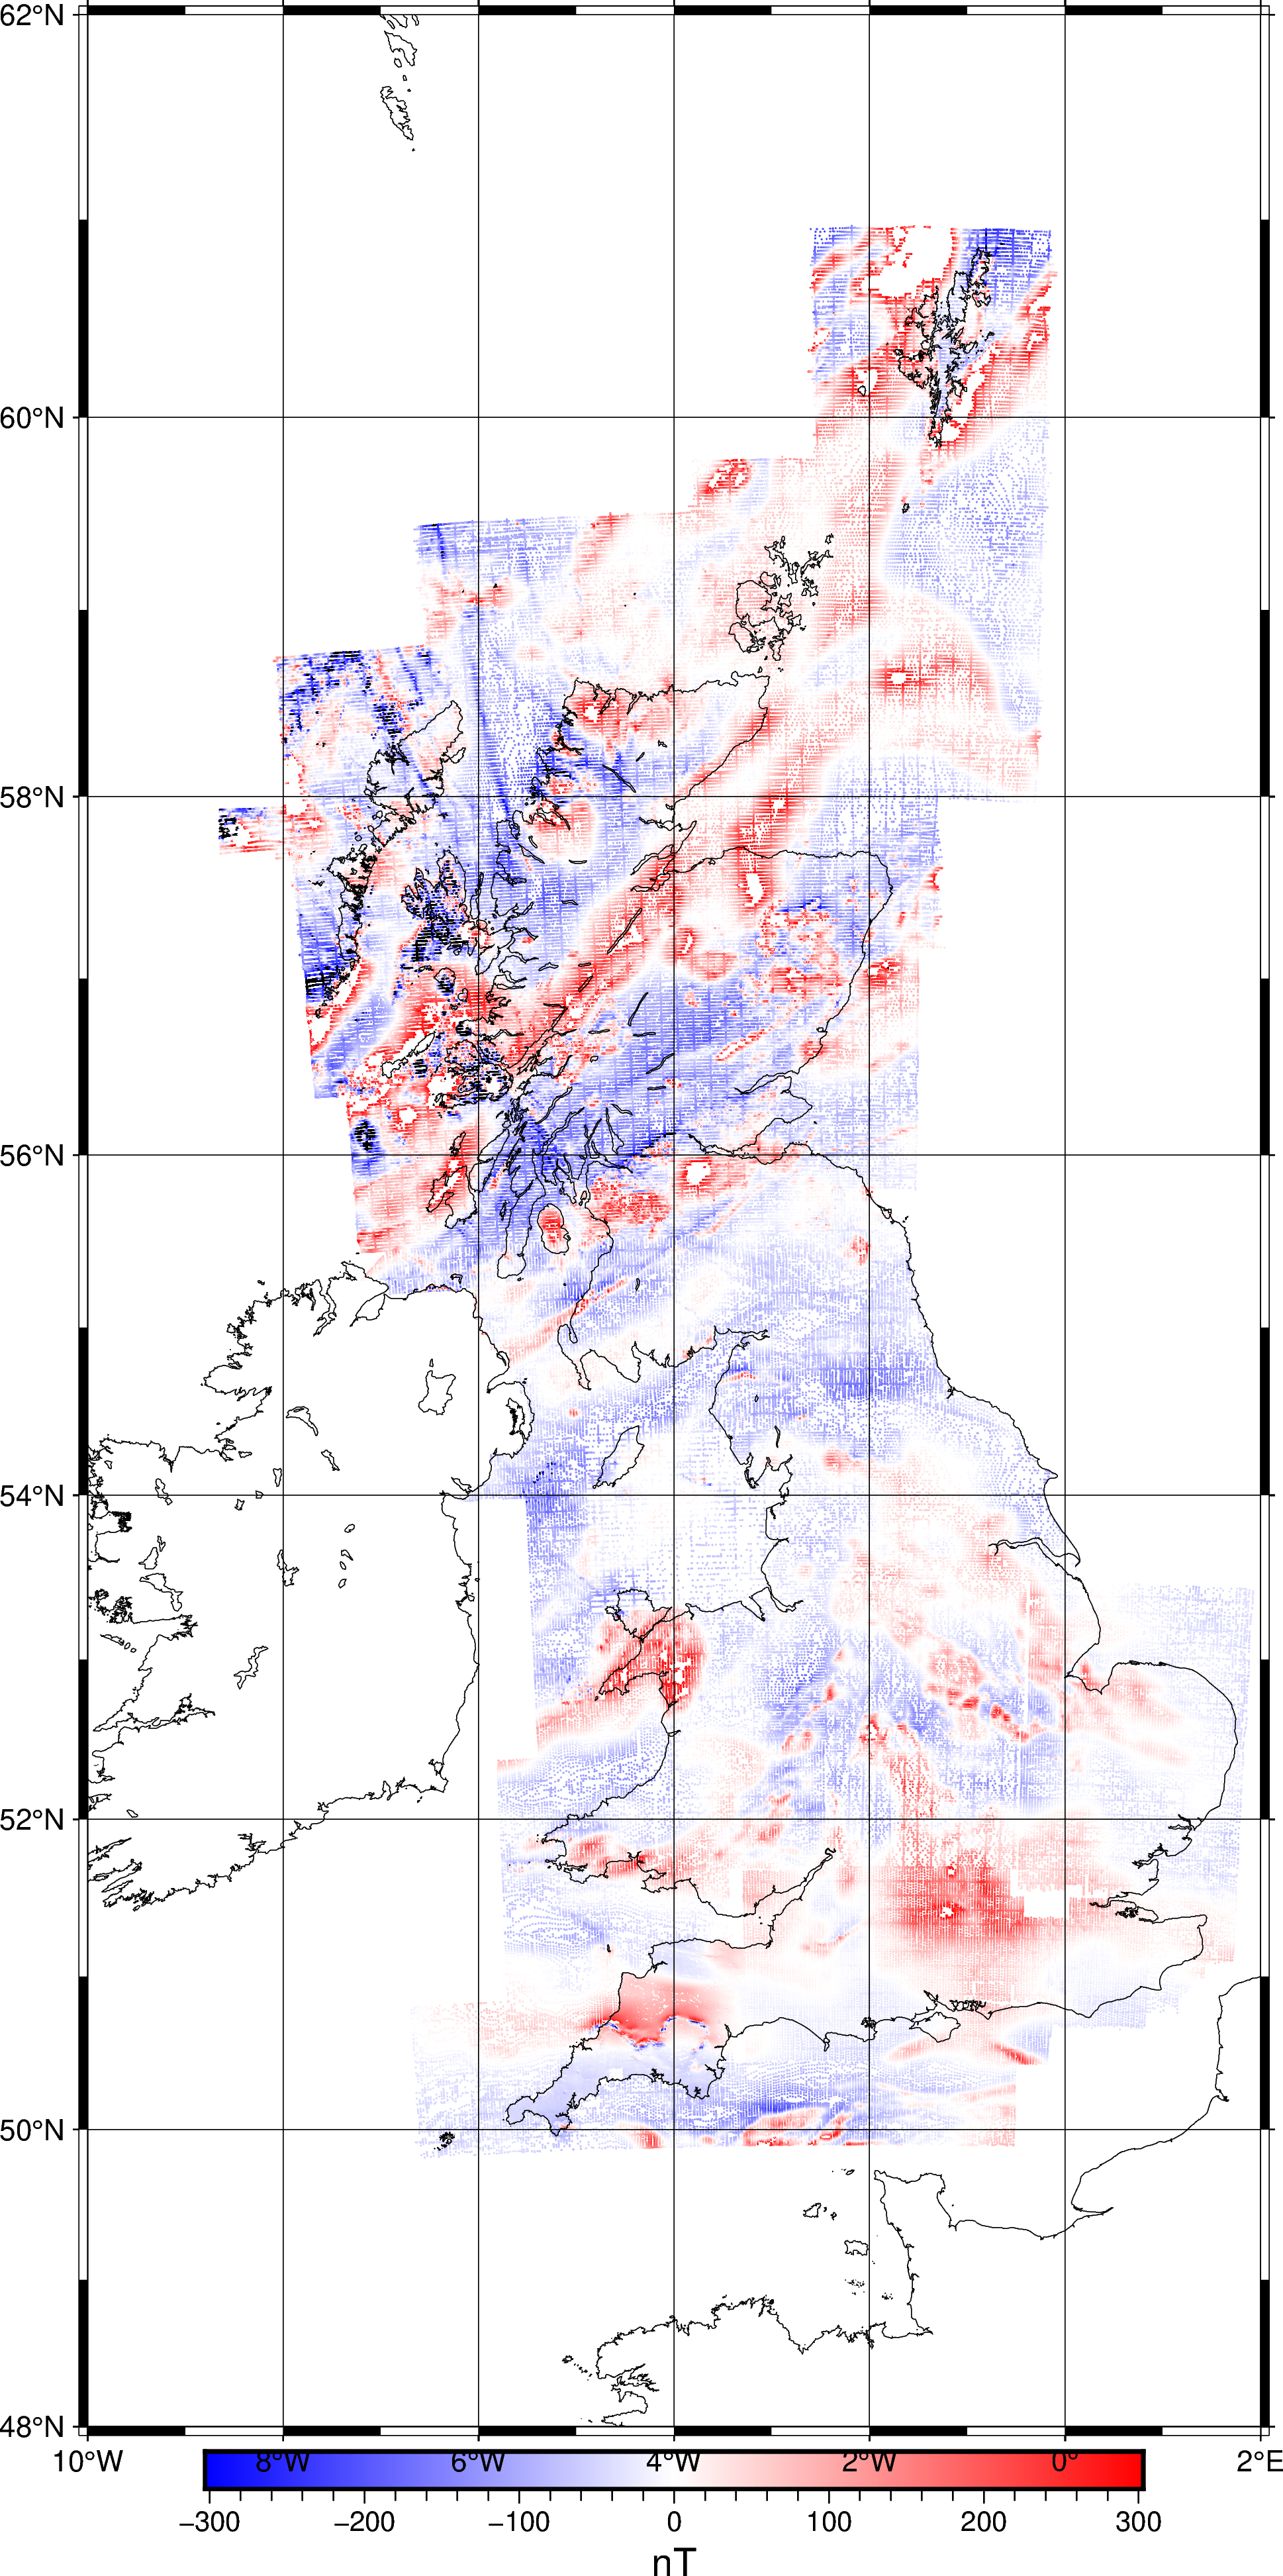

In [14]:
fig = pygmt.Figure()
scale = np.percentile(mag.total_field_anomaly_nt, 95)
pygmt.makecpt(cmap="polar", series=[-scale, scale])
fig.plot(x=mag.longitude, y=mag.latitude, style="c0.02c", color=mag.total_field_anomaly_nt, cmap=True, projection="M15c")
fig.colorbar(frame='af+l"nT"')
fig.coast(shorelines=True)
fig.basemap(frame="afg")
fig.show()